In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import json
import gpytorch
import torch
import tqdm
import os
import threading

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from matplotlib import pyplot as plt
from time import sleep
from typing import List, Union
from math import ceil


%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
def flatten_dict(x: dict, prefix=""):
    y = {}
    for k, v in x.items():
        if isinstance(v, dict):
            y.update(flatten_dict(v, k + "_"))
        else:
            y[prefix + k] = [v]
    return y

In [3]:
class ReturnValueThread(threading.Thread):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.result = None

    def run(self):
        if self._target is None:
            return  # could alternatively raise an exception, depends on the use case
        try:
            self.result = self._target(*self._args, **self._kwargs)
        except Exception as exc:
            print(f'{type(exc).__name__}: {exc}', file=sys.stderr)  # properly handle the exception

    def join(self, *args, **kwargs):
        super().join(*args, **kwargs)
        return self.result

In [4]:
def to_csv(file: str, name: str):
    df = pd.DataFrame()
    with open(file) as file:
        for line in file:
            nested_dict = json.loads(line)
            df = pd.concat([df, pd.DataFrame.from_dict(flatten_dict(nested_dict), orient='columns')], axis=0)
    df.reset_index(drop=True).to_csv(name)
    
def subprocess(folder: str):   
    chassis_file = os.path.join(folder, "env_learning_zip/chassis.txt")
    control_file = os.path.join(folder, "env_learning_zip/chassis.txt")
    localization_file = os.path.join(folder, "env_learning_zip/chassis.txt")
    
    
    

In [5]:
class DataLoader():
    def __init__(
        self,
        data_paths,
        include_dirs=None,
    ):
        self.data_paths = data_paths
        self.chassis_df = pd.DataFrame()
        self.control_df = pd.DataFrame()
        self.localization_df = pd.DataFrame()
        self.include_dirs = include_dirs
        
    def load_data(self):
        batch_index = 0
        for p in self.data_paths:
            for folder in os.listdir(p):
                
                if os.path.join(p, folder) not in self.include_dirs:
                    continue
            
                
                chassis_file = os.path.join(p, folder, "env_learning_zip/chassis.txt")
                control_file = os.path.join(p, folder, "env_learning_zip/control.txt")
                localization_file = os.path.join(p, folder, "env_learning_zip/localization.txt")
                
                if not os.path.exists(chassis_file) or not os.path.exists(control_file) or not os.path.exists(localization_file):
                    continue
                    
                chassis_df = pd.DataFrame()
                control_df = pd.DataFrame()
                localization_df = pd.DataFrame()

                            
                def task1(chassis_file, chassis_df):
                    with open(chassis_file) as file:
                        for line in file:
                            nested_dict = json.loads(line)
                            chassis_df = pd.concat([chassis_df, pd.DataFrame.from_dict(flatten_dict(nested_dict), orient='columns')], axis=0)
                    return chassis_df.reset_index(drop=True)
                    
                def task2(control_file, control_df):
                    with open(control_file) as file:
                        for line in file:
                            nested_dict = json.loads(line)
                            control_df = pd.concat([control_df, pd.DataFrame.from_dict(flatten_dict(nested_dict), orient='columns')], axis=0)
                    return control_df.reset_index(drop=True)
                    
                    
                def task3(localization_file, localization_df):
                    with open(localization_file) as file:
                        for line in file:
                            nested_dict = json.loads(line)
                            localization_df = pd.concat([localization_df, pd.DataFrame.from_dict(flatten_dict(nested_dict), orient='columns')], axis=0)
                    return localization_df.reset_index(drop=True)
                            
                t1 = ReturnValueThread(target=task1, args=(chassis_file, chassis_df))
                t2 = ReturnValueThread(target=task2, args=(control_file, control_df))
                t3 = ReturnValueThread(target=task3, args=(localization_file, localization_df))
                
                t1.start()
                t2.start()
                t3.start()
                
                chassis_df = t1.join()
                control_df = t2.join()
                localization_df = t3.join()

                if chassis_df.shape[0] != control_df.shape[0] or chassis_df.shape[0] != localization_df.shape[0] or control_df.shape[0] != localization_df.shape[0]:
                    continue
                        
                num_samples = chassis_df.shape[0]
                
                if num_samples == 0:
                    continue
                
                num_batches = 0
                n = 0
                if num_samples > 1000:
                    
                    num_batches = ceil(num_samples / 1000);
                   
                batch_indices = np.zeros(num_samples)
                
                for n in range(num_batches):
                    batch_indices[n * 1000 : (n + 1) * 1000] = batch_index
                    batch_index += 1
                    
                batch_indices[n * 1000:] = batch_index
                batch_index += 1
                
                chassis_df = pd.concat([chassis_df, pd.DataFrame(batch_indices, columns=["batch"])], axis=1)
                control_df = pd.concat([control_df, pd.DataFrame(batch_indices, columns=["batch"])], axis=1)
                localization_df = pd.concat([localization_df, pd.DataFrame(batch_indices, columns=["batch"])], axis=1)
                    
                self.chassis_df = pd.concat([self.chassis_df, chassis_df], axis=0)
                self.control_df = pd.concat([self.control_df, control_df], axis=0)
                self.localization_df = pd.concat([self.localization_df, localization_df], axis=0)
                
        return self.chassis_df.reset_index(drop=True), self.control_df.reset_index(drop=True), self.localization_df.reset_index(drop=True)

In [6]:
data_paths= ["/home/qb/workspace/dataset_downloader/1850281/processed"]

include_dirs=[
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982674857",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982683049",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982691241",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982699433",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982707625",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982715817",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982724009",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982732201",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982748585",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982756777",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982764969",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982773161",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982781353",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982674857",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982683049",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982691241",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982699433",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982707625",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982715817",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982724009",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982732201",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982748585",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982756777",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982764969",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982773161",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982781353",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982789545",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982797737",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982805929",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982814121",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982822313",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982830505",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982838697",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982846889",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982855081",
"/home/qb/workspace/dataset_downloader/1850281/processed/5771982863273",
]

include_dirs = set(include_dirs)

dl = DataLoader(data_paths, include_dirs)

In [7]:
if os.path.exists('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/chassis_training.csv') and \
os.path.exists('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/control_training.csv') and \
os.path.exists('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/localization_training.csv'):
    chassis_df = pd.read_csv('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/chassis_training.csv')
    control_df = pd.read_csv('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/control_training.csv')
    localization_df = pd.read_csv('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/localization_training.csv')

else:
    chassis_df, control_df, localization_df = dl.load_data()

    os.makedirs('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/', exist_ok=True)  
    chassis_df.to_csv('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/chassis_training.csv')
    control_df.to_csv('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/control_training.csv')
    localization_df.to_csv('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/localization_training.csv')

/tmp/ipykernel_16497/3594348819.py:4: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  chassis_df = pd.read_csv('/home/qb/workspace/dataset_downloader/1850281/processed/preprocessed/chassis_training.csv')


In [8]:
chassis_df

,Unnamed: 0,engineRpm,speedMps,fuelRangeM,throttlePercentage,brakePercentage,steeringPercentage,parkingBrake,highBeamSignal,drivingMode,...,cmdDrivingMode,driveMotorTorqueNm,batteryVoltage,batteryCurrent,enableButton,disableButton,batch,signal_horn,linearAccelerationVrf_x,linearAccelerationVrf_y
0,0,48.0,0.031275,1,0.0,6.0,-29.586666,False,False,COMPLETE_AUTO_DRIVE,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
1,1,50.0,0.031275,1,0.0,6.0,-29.586666,False,False,COMPLETE_AUTO_DRIVE,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
2,2,52.0,0.031275,1,0.0,6.0,-29.586666,False,False,COMPLETE_AUTO_DRIVE,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
3,3,51.0,0.031275,1,0.0,6.0,-29.586666,False,False,COMPLETE_AUTO_DRIVE,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
4,4,47.0,0.046913,1,0.0,6.0,-28.386667,False,False,COMPLETE_AUTO_DRIVE,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138595,138595,854.0,2.564550,1,0.0,2.0,-36.266666,False,False,COMPLETE_AUTO_DRIVE,...,1.0,0,556.6,4.0,False,False,167.0,NaN,NaN,NaN
138596,138596,854.0,2.564550,1,0.0,2.0,-36.266666,False,False,COMPLETE_AUTO_DRIVE,...,1.0,0,556.6,4.0,False,False,167.0,NaN,NaN,NaN
138597,138597,850.0,2.564550,1,0.0,2.0,-36.266666,False,False,COMPLETE_AUTO_DRIVE,...,1.0,0,556.6,4.0,False,False,167.0,NaN,NaN,NaN
138598,138598,849.0,2.548913,1,0.0,1.0,-36.266666,False,False,COMPLETE_AUTO_DRIVE,...,1.0,2,556.6,4.0,False,False,167.0,NaN,NaN,NaN


In [9]:
chassis_df.columns

Index(['Unnamed: 0', 'engineRpm', 'speedMps', 'fuelRangeM',
       'throttlePercentage', 'brakePercentage', 'steeringPercentage',
       'parkingBrake', 'highBeamSignal', 'drivingMode', 'errorCode',
       'gearLocation', 'header_timestampSec', 'header_moduleName',
       'signal_turnSignal', 'angularVelocityVrf_z', 'realSteeringAngle',
       'batterySoc', 'cmdDrivingMode', 'driveMotorTorqueNm', 'batteryVoltage',
       'batteryCurrent', 'enableButton', 'disableButton', 'batch',
       'signal_horn', 'linearAccelerationVrf_x', 'linearAccelerationVrf_y'],
      dtype='object')

(array([1.31166e+05, 4.60000e+01, 4.00000e+01, 4.10000e+01, 3.20000e+01,
        3.00000e+01, 6.70000e+01, 4.10000e+01, 9.60000e+01, 2.31000e+02,
        1.68000e+02, 3.13000e+02, 2.83000e+02, 3.56000e+02, 2.18000e+02,
        2.81000e+02, 5.69000e+02, 3.05000e+02, 2.64000e+02, 1.14000e+02,
        1.37000e+02, 2.13000e+02, 2.14000e+02, 1.37000e+02, 1.70000e+02,
        1.80000e+02, 1.50000e+01, 5.00000e+01, 1.37000e+02, 1.35000e+02,
        3.38000e+02, 8.20000e+01, 1.90000e+01, 1.14000e+02, 1.10000e+02,
        7.80000e+01, 2.70000e+01, 6.30000e+01, 6.70000e+01, 2.66000e+02,
        1.03000e+02, 2.40000e+01, 2.10000e+01, 2.20000e+01, 2.10000e+01,
        1.60000e+01, 4.00000e+00, 8.00000e+00, 1.00000e+01, 1.70000e+01,
        2.70000e+01, 9.00000e+00, 2.30000e+01, 3.10000e+01, 1.90000e+01,
        1.00000e+01, 3.60000e+01, 4.10000e+01, 5.00000e+00, 1.50000e+01,
        6.10000e+01, 1.30000e+01, 1.92000e+02, 1.60000e+01, 1.90000e+01,
        1.01000e+02, 5.00000e+00, 1.50000e+01, 1.50

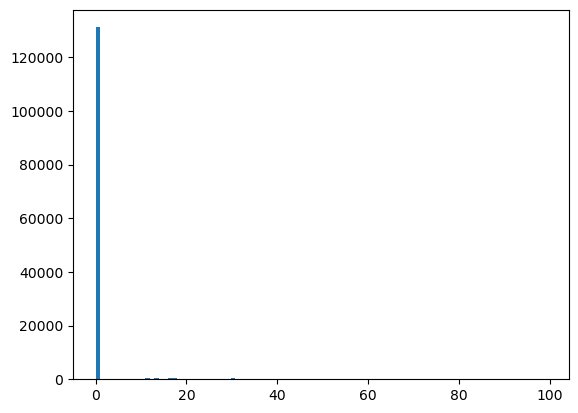

In [10]:
plt.hist(chassis_df['throttlePercentage'], bins=100)

In [11]:
control_df

,Unnamed: 0,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_cameraTimestamp,header_radarTimestamp,speedCmd,throttle,brake,...,parkingBrake,drivingMode,gearLocation,isEstop,signal_turnSignal,signal_horn,signal_emergencyLight,signal_beam,padMsg_action,batch
0,0,0,pad,0,1669108070800063,0,0,0,0.000000,17.084944,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
1,1,0,pad,0,1669108070800063,0,0,0,0.000000,17.013314,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
2,2,0,pad,0,1669108070800063,0,0,0,0.000000,16.942308,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
3,3,0,pad,0,1669108070800063,0,0,0,0.000000,16.872852,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
4,4,0,pad,0,1669108070800063,0,0,0,0.000000,16.805696,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138595,138595,0,pad,0,1669108744800434,0,0,0,0.000000,0.000210,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,167.0
138596,138596,0,pad,0,1669108744800434,0,0,0,5.086168,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,167.0
138597,138597,0,pad,0,1669108744800434,0,0,0,5.791995,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,167.0
138598,138598,0,pad,0,1669108744800434,0,0,0,6.432083,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,167.0


Index(['Unnamed: 0', 'header_timestampSec', 'header_moduleName',
       'header_sequenceNum', 'header_lidarTimestamp', 'header_cameraTimestamp',
       'header_radarTimestamp', 'speedCmd', 'throttle', 'brake',
       'steeringRate', 'steeringTarget', 'parkingBrake', 'drivingMode',
       'gearLocation', 'isEstop', 'signal_turnSignal', 'signal_horn',
       'signal_emergencyLight', 'signal_beam', 'padMsg_action', 'batch'],
      dtype='object')

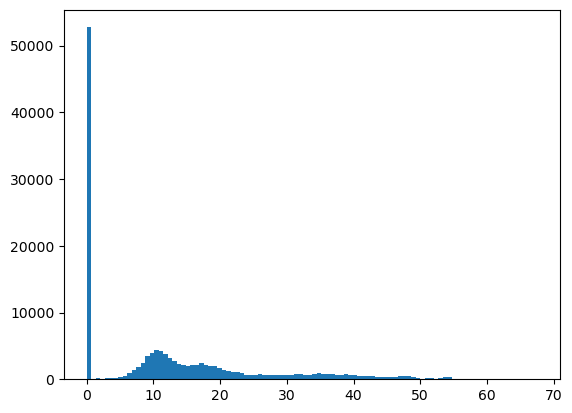

In [12]:
plt.hist(control_df['throttle'], bins=100)
control_df.columns

In [13]:
localization_df

,Unnamed: 0,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_version,position_x,position_y,position_z,orientation_qx,...,linearAccelerationStdDev_x,linearAccelerationStdDev_y,linearAccelerationStdDev_z,measurementTime,jerk_x,jerk_y,jerk_z,odom_heading,mode,batch
0,0,1.669108e+09,localization,39423,1669108070900075,0,-596.237992,498.776830,-4.948931,0.000491,...,2.351154,10.365064,-5.973130,1.669108e+09,-0.362498,6.207997,6.345851,-1.076037,ABSOLUTE_MODE,0.0
1,1,1.669108e+09,localization,39424,1669108070900075,0,-596.237575,498.765611,-4.895154,0.000460,...,2.088227,10.197176,-7.206662,1.669108e+09,-1.401590,6.066476,5.910070,-1.076099,ABSOLUTE_MODE,0.0
2,2,1.669108e+09,localization,39425,1669108070900075,0,-596.237085,498.753805,-4.846383,0.000430,...,1.663594,9.730191,-7.154324,1.669108e+09,-0.941970,5.924004,7.214666,-1.076181,ABSOLUTE_MODE,0.0
3,3,1.669108e+09,localization,39426,1669108070900075,0,-596.232689,498.579354,-4.850709,0.000444,...,1.332061,9.674473,-6.897264,1.669108e+09,-0.904239,5.979208,4.142262,-1.076282,ABSOLUTE_MODE,0.0
4,4,1.669108e+09,localization,39427,1669108070900075,0,-596.231918,498.583231,-4.955966,0.000491,...,1.045077,9.842283,-6.852104,1.669108e+09,-0.204324,6.188551,5.347309,-1.076382,ABSOLUTE_MODE,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138595,138595,1.669109e+09,localization,106819,1669108744800434,0,-605.281173,510.706565,-17.912437,0.001477,...,0.119027,-0.771648,0.546967,1.669109e+09,-0.377983,-0.391044,-0.049206,-0.820946,ABSOLUTE_MODE,167.0
138596,138596,1.669109e+09,localization,106820,1669108744800434,0,-605.281030,510.705628,-17.910226,0.001477,...,0.204068,-0.685471,0.661778,1.669109e+09,-0.499580,-0.422051,-0.209383,-0.822604,ABSOLUTE_MODE,167.0
138597,138597,1.669109e+09,localization,106821,1669108744800434,0,-605.280140,510.705846,-17.956195,0.001478,...,0.175148,-0.667728,0.525756,1.669109e+09,-0.584081,-0.425600,-0.105339,-0.824256,ABSOLUTE_MODE,167.0
138598,138598,1.669109e+09,localization,106822,1669108744800434,0,-605.280017,510.704965,-17.953656,0.001478,...,0.102080,-0.579310,0.312158,1.669109e+09,-0.666969,-0.206479,0.171571,-0.825899,ABSOLUTE_MODE,167.0


Index(['Unnamed: 0', 'header_timestampSec', 'header_moduleName',
       'header_sequenceNum', 'header_lidarTimestamp', 'header_version',
       'position_x', 'position_y', 'position_z', 'orientation_qx',
       'orientation_qy', 'orientation_qz', 'orientation_qw',
       'linearVelocity_x', 'linearVelocity_y', 'linearVelocity_z',
       'linearAcceleration_x', 'linearAcceleration_y', 'linearAcceleration_z',
       'angularVelocity_x', 'angularVelocity_y', 'angularVelocity_z',
       'pose_heading', 'linearAccelerationVrf_x', 'linearAccelerationVrf_y',
       'linearAccelerationVrf_z', 'angularVelocityVrf_x',
       'angularVelocityVrf_y', 'angularVelocityVrf_z', 'linearVelocityVrf_x',
       'linearVelocityVrf_y', 'linearVelocityVrf_z', 'positionStdDev_x',
       'positionStdDev_y', 'positionStdDev_z', 'orientationStdDev_x',
       'orientationStdDev_y', 'orientationStdDev_z',
       'linearAccelerationStdDev_x', 'linearAccelerationStdDev_y',
       'linearAccelerationStdDev_z', 'measu

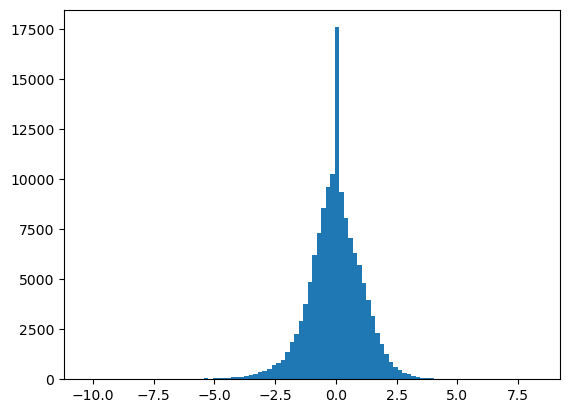

In [14]:
plt.hist(localization_df['linearAccelerationVrf_y'], bins=100)
localization_df.columns

In [15]:
def RemoveUnwantedData(x: pd.DataFrame):
    index = x["drivingMode"] == "COMPLETE_AUTO_DRIVE"
    x = x[index]
    return x, index

def AddRelativeTime(x: pd.DataFrame):
    if "dt" in x.columns:
        return x
    
    if "timestamp" not in x.columns:
        raise Exception("Not timestamp")
        
    num_data_point = x.shape[0]
        
    relative_time = x.iloc[1:num_data_point]["timestamp"].to_numpy() - x.iloc[0:num_data_point-1]["timestamp"].to_numpy()
    relative_time = np.append(relative_time, 0.0)   
    
    x['dt'] = relative_time
    return x

def TimeSeriesData(raw_data: pd.DataFrame, state_columns: List[str], observ_columns: List[str]):
    
    data = None
    if "dt" not in raw_data.columns:
        data = AddRelativeTime(raw_data)
    else:
        data = raw_data
        
    num_data_point = data.shape[0]
    
    
    
    if(any(entity not in data.columns for entity in state_columns)):
        raise Exception("Unknown state")
    
    if(any(entity not in data.columns for entity in observ_columns)):
        raise Exception("Unknown observation")
    
    x_index = np.logical_and([data["dt"] < 0.5], [data["dt"] > 0.0]).flatten()
    y_index = np.append(x_index, x_index[-1])[1:].flatten()
        
    X = data[x_index][state_columns + ["dt"]]
    Y = data[y_index][observ_columns]

        
    return X, Y, x_index, y_index

def NormalizeData(x: pd.DataFrame, shifter: Union[None, np.array] = None, normalizer: Union[None, np.array] = None, has_batch=True):
    X = x
    if has_batch:
        X = x[x.columns[x.columns != "batch"]]
        batch = x["batch"]
    
    if shifter is None:
        shifter = X.min()
        
    X = X - shifter
    
    if normalizer is None:
        normalizer = X.max()

    X = 2 * (X / normalizer) - 1
    
    if has_batch:
        return pd.concat([X, batch], axis=1), shifter, normalizer
    else:
        return X, shifter, normalizer

def DeNormalizeData(x: np.array, shifter: np.array, normalizer: np.array):
    return (x + 1.0) / 2.0 * normalizer + shifter

In [16]:
chassis_features = ['engineRpm', 
                    'speedMps', 
                    'driveMotorTorqueNm']

control_features = ['throttle', 
                    'brake']

localization_features = ["linearVelocityVrf_y", 
                         "linearAccelerationVrf_y"]


In [17]:
chassis_df = chassis_df.reset_index(drop=True)
control_df = control_df.reset_index(drop=True)
localization_df = localization_df.reset_index(drop=True)

In [18]:
chassis_df_v, valid_index = RemoveUnwantedData(chassis_df)

In [19]:
print(chassis_df.shape)
print(control_df.shape)
print(localization_df.shape)

(138600, 28)
(138600, 22)
(138600, 48)


In [20]:
valid_index.shape

(138600,)

(array([  727.,   183.,   119.,    88.,    62.,    40.,    49.,    42.,
           73.,    66.,    56.,    45.,    56.,    58.,    52.,    59.,
           72.,   135.,    88.,   189.,   325.,   362.,   250.,   196.,
          206.,   183.,   326.,   346.,   297.,   318.,   311.,   369.,
          570.,   899.,   787.,   666.,   882.,   723.,   759.,   668.,
          772.,  1356.,   905.,  2223.,  2832.,  1476.,   949.,   881.,
         1239.,  1471.,  1223.,  1283.,  1209.,  1787.,  1230.,  1002.,
         1294.,  2149.,  5705.,   721.,   546.,   913.,  1383.,   630.,
          573.,   647.,   719.,   884.,   924.,  1037.,  1196.,   839.,
          731.,   789.,   880.,  1194.,  1008.,  1189.,  1042.,   814.,
          785.,   904.,  1018.,  1083.,  1205.,  1121.,  1557.,  2354.,
         2901.,  2134.,  1649.,  1187.,  1483.,  1642.,  2429.,  5819.,
        19604.,  2028.,   483.,   151.]),
 array([   0.  ,   42.91,   85.82,  128.73,  171.64,  214.55,  257.46,
         300.37,  343.2

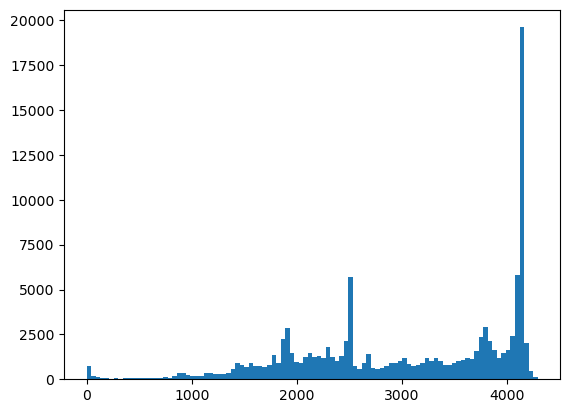

In [21]:
plt.hist(chassis_df_v['engineRpm'], bins=100)

In [22]:
chassis_df_v = chassis_df_v.reset_index()
control_df_v  = control_df[valid_index].reset_index()
localization_df_v = localization_df[valid_index].reset_index()

In [23]:
chassis_df_v

,index,Unnamed: 0,engineRpm,speedMps,fuelRangeM,throttlePercentage,brakePercentage,steeringPercentage,parkingBrake,highBeamSignal,...,cmdDrivingMode,driveMotorTorqueNm,batteryVoltage,batteryCurrent,enableButton,disableButton,batch,signal_horn,linearAccelerationVrf_x,linearAccelerationVrf_y
0,0,0,48.0,0.031275,1,0.0,6.0,-29.586666,False,False,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
1,1,1,50.0,0.031275,1,0.0,6.0,-29.586666,False,False,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
2,2,2,52.0,0.031275,1,0.0,6.0,-29.586666,False,False,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
3,3,3,51.0,0.031275,1,0.0,6.0,-29.586666,False,False,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
4,4,4,47.0,0.046913,1,0.0,6.0,-28.386667,False,False,...,1.0,0,556.8,8.7,False,False,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112879,138595,138595,854.0,2.564550,1,0.0,2.0,-36.266666,False,False,...,1.0,0,556.6,4.0,False,False,167.0,NaN,NaN,NaN
112880,138596,138596,854.0,2.564550,1,0.0,2.0,-36.266666,False,False,...,1.0,0,556.6,4.0,False,False,167.0,NaN,NaN,NaN
112881,138597,138597,850.0,2.564550,1,0.0,2.0,-36.266666,False,False,...,1.0,0,556.6,4.0,False,False,167.0,NaN,NaN,NaN
112882,138598,138598,849.0,2.548913,1,0.0,1.0,-36.266666,False,False,...,1.0,2,556.6,4.0,False,False,167.0,NaN,NaN,NaN


In [24]:
control_df_v

,index,Unnamed: 0,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_cameraTimestamp,header_radarTimestamp,speedCmd,throttle,...,parkingBrake,drivingMode,gearLocation,isEstop,signal_turnSignal,signal_horn,signal_emergencyLight,signal_beam,padMsg_action,batch
0,0,0,0,pad,0,1669108070800063,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
1,1,1,0,pad,0,1669108070800063,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
2,2,2,0,pad,0,1669108070800063,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
3,3,3,0,pad,0,1669108070800063,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
4,4,4,0,pad,0,1669108070800063,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112879,138595,138595,0,pad,0,1669108744800434,0,0,0,0.000000,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,167.0
112880,138596,138596,0,pad,0,1669108744800434,0,0,0,5.086168,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,167.0
112881,138597,138597,0,pad,0,1669108744800434,0,0,0,5.791995,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,167.0
112882,138598,138598,0,pad,0,1669108744800434,0,0,0,6.432083,...,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_RIGHT,False,False,BEAM_NULL,1,167.0


In [25]:
localization_df_v

,index,Unnamed: 0,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_version,position_x,position_y,position_z,...,linearAccelerationStdDev_x,linearAccelerationStdDev_y,linearAccelerationStdDev_z,measurementTime,jerk_x,jerk_y,jerk_z,odom_heading,mode,batch
0,0,0,1.669108e+09,localization,39423,1669108070900075,0,-596.237992,498.776830,-4.948931,...,2.351154,10.365064,-5.973130,1.669108e+09,-0.362498,6.207997,6.345851,-1.076037,ABSOLUTE_MODE,0.0
1,1,1,1.669108e+09,localization,39424,1669108070900075,0,-596.237575,498.765611,-4.895154,...,2.088227,10.197176,-7.206662,1.669108e+09,-1.401590,6.066476,5.910070,-1.076099,ABSOLUTE_MODE,0.0
2,2,2,1.669108e+09,localization,39425,1669108070900075,0,-596.237085,498.753805,-4.846383,...,1.663594,9.730191,-7.154324,1.669108e+09,-0.941970,5.924004,7.214666,-1.076181,ABSOLUTE_MODE,0.0
3,3,3,1.669108e+09,localization,39426,1669108070900075,0,-596.232689,498.579354,-4.850709,...,1.332061,9.674473,-6.897264,1.669108e+09,-0.904239,5.979208,4.142262,-1.076282,ABSOLUTE_MODE,0.0
4,4,4,1.669108e+09,localization,39427,1669108070900075,0,-596.231918,498.583231,-4.955966,...,1.045077,9.842283,-6.852104,1.669108e+09,-0.204324,6.188551,5.347309,-1.076382,ABSOLUTE_MODE,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112879,138595,138595,1.669109e+09,localization,106819,1669108744800434,0,-605.281173,510.706565,-17.912437,...,0.119027,-0.771648,0.546967,1.669109e+09,-0.377983,-0.391044,-0.049206,-0.820946,ABSOLUTE_MODE,167.0
112880,138596,138596,1.669109e+09,localization,106820,1669108744800434,0,-605.281030,510.705628,-17.910226,...,0.204068,-0.685471,0.661778,1.669109e+09,-0.499580,-0.422051,-0.209383,-0.822604,ABSOLUTE_MODE,167.0
112881,138597,138597,1.669109e+09,localization,106821,1669108744800434,0,-605.280140,510.705846,-17.956195,...,0.175148,-0.667728,0.525756,1.669109e+09,-0.584081,-0.425600,-0.105339,-0.824256,ABSOLUTE_MODE,167.0
112882,138598,138598,1.669109e+09,localization,106822,1669108744800434,0,-605.280017,510.704965,-17.953656,...,0.102080,-0.579310,0.312158,1.669109e+09,-0.666969,-0.206479,0.171571,-0.825899,ABSOLUTE_MODE,167.0


In [26]:
train_x_batch = pd.DataFrame()
train_y_batch = pd.DataFrame()

In [27]:
num_batches = chassis_df.iloc[-1]["batch"] + 1
print(num_batches)

168.0


In [28]:
for b in range(int(num_batches)):
    chassis_b = chassis_df_v[chassis_df_v["batch"] == b].reset_index(drop=True)
    localization_b = localization_df_v[localization_df_v["batch"] == b].reset_index(drop=True)
    control_b = control_df_v[control_df_v["batch"] == b].reset_index(drop=True)
    
    num_samples = chassis_b.shape[0] - 1
    
    train_x = pd.concat(
        [chassis_b.loc[0:num_samples-1, chassis_features].reset_index(drop=True), 
         localization_b.loc[0:num_samples-1, localization_features].reset_index(drop=True), 
         localization_b.loc[1:num_samples, localization_features].reset_index(drop=True)], 
        ignore_index=True,
        axis=1)
    
    train_x["batch"] = b

    train_y = pd.DataFrame(control_b.loc[0:num_samples-1, control_features[0]] - control_df_v.loc[0:num_samples-1, control_features[1]])
    
    train_y["batch"] = b
    print(train_y)
    
    
    train_x_batch = pd.concat([train_x_batch, train_x], axis=0, ignore_index=True)
    train_y_batch = pd.concat([train_y_batch, train_y], axis=0, ignore_index=True)    

             0  batch
0   -17.084944      0
1   -17.013314      0
2   -16.942308      0
3   -16.872852      0
4   -16.805696      0
..         ...    ...
165  29.724922      0
166  29.846455      0
167  30.245482      0
168  30.340186      0
169  30.446511      0

[170 rows x 2 columns]
             0  batch
0    13.599223      1
1    13.804480      1
2    14.024110      1
3    14.226053      1
4    14.460242      1
..         ...    ...
994  31.660959      1
995  31.782327      1
996  31.856735      1
997  31.944661      1
998  32.041084      1

[999 rows x 2 columns]
             0  batch
0    15.093608      2
1    15.270645      2
2    15.393949      2
3    15.538764      2
4    15.680931      2
..         ...    ...
994   0.000000      2
995   0.000000      2
996   0.000000      2
997   0.000000      2
998   0.000000      2

[999 rows x 2 columns]
             0  batch
0   -17.084944      3
1   -17.013314      3
2   -16.942308      3
3   -16.872852      3
4   -16.805696      3
..  

            0  batch
0    6.115989     48
1    6.137011     48
2    6.179716     48
3    6.243573     48
4    6.332099     48
..        ...    ...
994  9.125522     48
995  0.000000     48
996  0.000000     48
997  0.000000     48
998  9.142726     48

[999 rows x 2 columns]
             0  batch
0    -7.502458     49
1    -7.946234     49
2    -8.026461     49
3    -8.177666     49
4   -16.805696     49
..         ...    ...
994   8.266224     49
995   7.920164     49
996   7.804690     49
997   7.674808     49
998   7.477184     49

[999 rows x 2 columns]
             0  batch
0   -10.025646     50
1   -10.091333     50
2   -10.310636     50
3   -16.872852     50
4   -16.805696     50
..         ...    ...
994  17.728208     50
995  17.827676     50
996  17.838926     50
997  17.752339     50
998  17.691655     50

[999 rows x 2 columns]
             0  batch
0     0.458744     51
1    -0.301296     51
2    -0.077147     51
3    -0.096126     51
4     0.007540     51
..         ...  

Empty DataFrame
Columns: [0, batch]
Index: []
            0  batch
0    9.368718    109
1    9.450600    109
2    9.486557    109
3    9.512878    109
4    9.520789    109
..        ...    ...
994  0.000000    109
995  0.000000    109
996  0.000000    109
997  0.000000    109
998  0.000000    109

[999 rows x 2 columns]
             0  batch
0   -17.084944    110
1   -17.013314    110
2   -16.942308    110
3   -16.872852    110
4   -16.805696    110
..         ...    ...
635   0.000000    110
636   0.000000    110
637   0.000000    110
638   0.000000    110
639   0.000000    110

[640 rows x 2 columns]
Empty DataFrame
Columns: [0, batch]
Index: []
Empty DataFrame
Columns: [0, batch]
Index: []
Empty DataFrame
Columns: [0, batch]
Index: []
             0  batch
0   -10.569328    114
1    -9.916476    114
2    -9.349042    114
3    -8.658470    114
4    -7.804501    114
..         ...    ...
266  48.491981    114
267  48.512696    114
268  48.534044    114
269  48.565830    114
270  48.59

             0  batch
0     6.467892    163
1     7.506408    163
2     8.294718    163
3     8.884634    163
4     9.069547    163
..         ...    ...
994  39.614807    163
995  39.170144    163
996  38.755914    163
997  38.339745    163
998  37.941354    163

[999 rows x 2 columns]
             0  batch
0    20.351347    164
1    19.946062    164
2    19.832122    164
3    19.621755    164
4    19.473048    164
..         ...    ...
994   0.000000    164
995   0.000000    164
996   0.000000    164
997   0.000000    164
998   0.000000    164

[999 rows x 2 columns]
             0  batch
0   -17.084944    165
1   -17.013314    165
2   -16.942308    165
3   -16.872852    165
4   -16.805696    165
..         ...    ...
994  23.323332    165
995  23.320190    165
996  23.288231    165
997  23.377254    165
998  23.467928    165

[999 rows x 2 columns]
Empty DataFrame
Columns: [0, batch]
Index: []
            0  batch
0    5.613719    167
1    6.095666    167
2    6.003819    167
3    5

In [29]:
train_x_batch

,0,1,2,3,4,5,6,batch
0,48.0,0.031275,0,-0.093363,2.950483,-0.080138,2.970933,0
1,50.0,0.031275,0,-0.080138,2.970933,-0.067341,2.839855,0
2,52.0,0.031275,0,-0.067341,2.839855,-0.065502,2.908910,0
3,51.0,0.031275,0,-0.065502,2.908910,-0.066737,3.088381,0
4,47.0,0.046913,0,-0.066737,3.088381,-0.053241,3.160013,0
...,...,...,...,...,...,...,...,...
112750,856.0,2.564550,3,2.581019,-0.987714,2.575109,-0.941061,167
112751,854.0,2.564550,0,2.575109,-0.941061,2.569568,-0.905645,167
112752,854.0,2.564550,0,2.569568,-0.905645,2.562846,-0.903639,167
112753,850.0,2.564550,0,2.562846,-0.903639,2.557135,-0.866113,167


In [30]:
train_y_batch

,0,batch
0,-17.084944,0
1,-17.013314,0
2,-16.942308,0
3,-16.872852,0
4,-16.805696,0
...,...,...
112750,-0.009653,167
112751,0.000000,167
112752,5.086168,167
112753,5.791995,167


In [31]:
train_x_n, x_shifter, x_normalizer = NormalizeData(train_x_batch)
train_y_n, y_shifter, y_normalizer = NormalizeData(train_y_batch)

(array([1169., 1998., 1998.,  999., 1998., 1998.,  999.,  999., 1098.,
         999.,  441.,  201.,  999., 1998., 1998.,  669., 1998., 1998.,
         640.,    0.,    0.,  856., 1998., 1998.,  999.,  899., 1998.,
         999., 1998., 1998.,  999.,  899.,  944.,  999.,  814.,    0.,
         999., 1998.,  299.,  999., 1998.,  313.,  999., 1998.,  199.,
         999., 1998., 1998.,  999.,  830.,    4.,    0., 1842., 1998.,
           0., 1398., 1998.,  999., 1998.,  817.,    0.,  999., 1312.,
           0.,    0., 1639.,    0.,    0., 1270.,  999., 1998., 1998.,
         999., 1998., 1998.,  999.,   99., 1998.,  999., 1998.,  172.,
           0., 1998., 1460.,    0.,  365., 1998.,  502.,    0.,  999.,
         999., 1169.,  299.,  326., 1998., 1998.,  999., 1998., 1998.,
         899.]),
 array([  0.  ,   1.67,   3.34,   5.01,   6.68,   8.35,  10.02,  11.69,
         13.36,  15.03,  16.7 ,  18.37,  20.04,  21.71,  23.38,  25.05,
         26.72,  28.39,  30.06,  31.73,  33.4 ,  35.07,  3

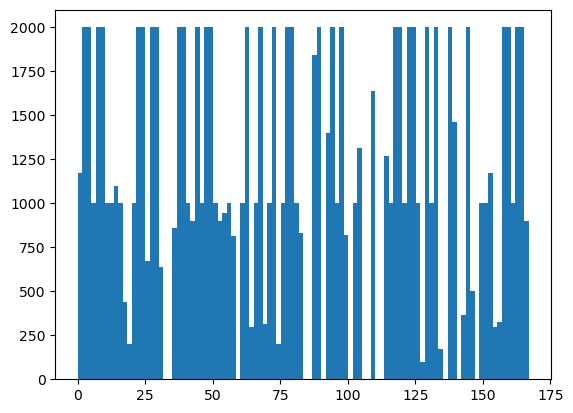

In [32]:
plt.hist(train_x_n["batch"], bins=100)

In [33]:
train_x_n.columns

Index([0, 1, 2, 3, 4, 5, 6, 'batch'], dtype='object')

In [34]:
train_y_n[train_y_n["batch"]==4].shape

(999, 2)

In [35]:
if len(train_y_n.shape) == 1:
    train_y_n = train_y_n.reshape(train_y_n.shape[0], -1)

In [36]:
# num_latents = 100
# latent_features = 8
# num_tasks = 1 if len(train_y_n.shape) == 1 else train_y_n.shape[1]

# class MultitaskGPModel(gpytorch.models.ApproximateGP):
#     def __init__(self):
#         # Let's use a different set of inducing points for each latent function
#         inducing_points = torch.rand(num_latents, latent_features, train_x_n.shape[1] - 1)

#         # We have to mark the CholeskyVariationalDistribution as batch
#         # so that we learn a variational distribution for each task
#         variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
#             inducing_points.size(-2), batch_shape=torch.Size([num_latents])
#         )

#         # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
#         # so that the output will be a MultitaskMultivariateNormal rather than a batch output
#         variational_strategy = gpytorch.variational.LMCVariationalStrategy(
#             gpytorch.variational.VariationalStrategy(
#                 self, inducing_points, variational_distribution, learn_inducing_locations=True
#             ),
#             num_tasks=num_tasks,
#             num_latents=num_latents,
#             latent_dim=-1
#         )

#         super().__init__(variational_strategy)

#         # The mean and covariance modules should be marked as batch
#         # so we learn a different set of hyperparameters
#         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
#         self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
#             batch_shape=torch.Size([num_latents])
#         )

#     def forward(self, x):
#         # The forward function should be written as if we were dealing with each output
#         # dimension in batch
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [37]:
# model = MultitaskGPModel().cuda()
# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).cuda()

In [38]:
# class GPRegressionModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = ConstantMean()
#         self.base_covar_module = RBFKernel()
#         self.covar_module = ProductStructureKernel(
#             ScaleKernel(
#                 GridInterpolationKernel(self.base_covar_module, grid_size=100, num_dims=1)
#             ), num_dims=18
#         )

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return MultivariateNormal(mean_x, covar_x)

In [39]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = torch.randn(128, train_x.shape[-1] - 1, dtype=torch.float)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# if torch.cuda.is_available():
#     model = model.cuda()
#     likelihood = likelihood.cuda()

In [41]:
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 300


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)


scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y_n.shape[0])

writer = SummaryWriter()


# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    
    optimizer.zero_grad()
    
    start_index = 0
    
    losses = []
    

    for b in range(int(num_batches)):
        batch = torch.tensor(train_x_n[train_x_n["batch"]==b].filter(items=[0, 1, 2, 3, 4, 5, 6]).to_numpy(), dtype=torch.float, requires_grad=False)
        
        if batch.shape[0] == 0:
            continue
        target = torch.tensor(train_y_n[train_y_n["batch"]==b].filter(items=[0]).to_numpy(), dtype=torch.float)
        output = model(batch)
        loss = -mll(output, target.flatten())
        loss.backward()
        losses.append(loss.item())
    
    total_loss = sum(losses)
    
    epochs_iter.set_postfix(loss=total_loss)
    writer.add_scalar('Loss/train', total_loss, i)
    optimizer.step()
    scheduler.step()
    torch.cuda.empty_cache()
    
writer.close()

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [06:39<00:00,  1.33s/it, loss=-51.1]


In [42]:
torch.save(model.state_dict(), 'longitudinal_dynamics_svgp.pth')
torch.save(likelihood.state_dict(), 'longitudinal_dynamics_likelihood.pth')

In [43]:
chassis_df_t = pd.DataFrame()
control_df_t = pd.DataFrame()
localization_df_t = pd.DataFrame()

In [56]:
with open("/home/qb/workspace/dataset_downloader/1850281/processed/5772550601641/env_learning_zip/chassis.txt") as file:
    for line in file:
        nested_dict = json.loads(line)
        chassis_df_t = pd.concat([chassis_df_t, pd.DataFrame.from_dict(flatten_dict(nested_dict), orient='columns')], axis=0)
        

with open("/home/qb/workspace/dataset_downloader/1850281/processed/5772550601641/env_learning_zip/control.txt") as file:
    for line in file:
        nested_dict = json.loads(line)
        control_df_t = pd.concat([control_df_t, pd.DataFrame.from_dict(flatten_dict(nested_dict), orient='columns')], axis=0)
        
with open("/home/qb/workspace/dataset_downloader/1850281/processed/5772550601641/env_learning_zip/localization.txt") as file:
    for line in file:
        nested_dict = json.loads(line)
        localization_df_t = pd.concat([localization_df_t, pd.DataFrame.from_dict(flatten_dict(nested_dict), orient='columns')], axis=0)

Index(['header_timestampSec', 'header_moduleName', 'header_sequenceNum',
       'header_lidarTimestamp', 'header_cameraTimestamp',
       'header_radarTimestamp', 'speedCmd', 'throttle', 'brake',
       'steeringRate', 'steeringTarget', 'parkingBrake', 'drivingMode',
       'gearLocation', 'isEstop', 'signal_turnSignal', 'signal_horn',
       'signal_emergencyLight', 'signal_beam', 'padMsg_action'],
      dtype='object')

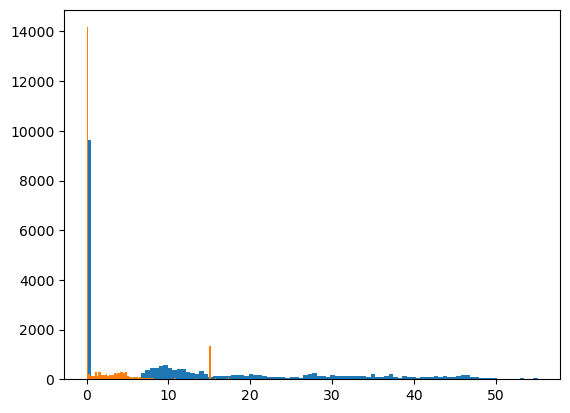

In [57]:
plt.hist(control_df_t['throttle'], bins=100)
plt.hist(control_df_t['brake'], bins=100)
control_df_t.columns

Index(['header_timestampSec', 'header_moduleName', 'header_sequenceNum',
       'header_lidarTimestamp', 'header_version', 'position_x', 'position_y',
       'position_z', 'orientation_qx', 'orientation_qy', 'orientation_qz',
       'orientation_qw', 'linearVelocity_x', 'linearVelocity_y',
       'linearVelocity_z', 'linearAcceleration_x', 'linearAcceleration_y',
       'linearAcceleration_z', 'angularVelocity_x', 'angularVelocity_y',
       'angularVelocity_z', 'pose_heading', 'linearAccelerationVrf_x',
       'linearAccelerationVrf_y', 'linearAccelerationVrf_z',
       'angularVelocityVrf_x', 'angularVelocityVrf_y', 'angularVelocityVrf_z',
       'linearVelocityVrf_x', 'linearVelocityVrf_y', 'linearVelocityVrf_z',
       'positionStdDev_x', 'positionStdDev_y', 'positionStdDev_z',
       'orientationStdDev_x', 'orientationStdDev_y', 'orientationStdDev_z',
       'linearAccelerationStdDev_x', 'linearAccelerationStdDev_y',
       'linearAccelerationStdDev_z', 'measurementTime', 'jerk_x'

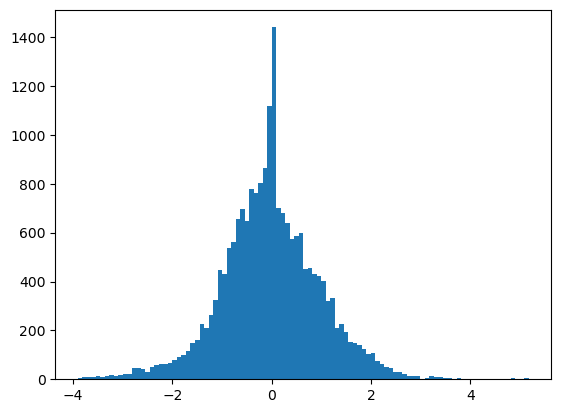

In [58]:
plt.hist(localization_df_t['linearAccelerationVrf_y'], bins=100)
localization_df_t.columns

In [59]:
chassis_df_t_v, valid_index_t = RemoveUnwantedData(chassis_df_t)

In [65]:
control_df_t.reset_index(drop=True)[valid_index_t.reset_index(drop=True)]

/tmp/ipykernel_16497/3233768636.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_df_t.reset_index(drop=True)[valid_index_t.reset_index(drop=True)]


,header_timestampSec,header_moduleName,header_sequenceNum,header_lidarTimestamp,header_cameraTimestamp,header_radarTimestamp,speedCmd,throttle,brake,steeringRate,steeringTarget,parkingBrake,drivingMode,gearLocation,isEstop,signal_turnSignal,signal_horn,signal_emergencyLight,signal_beam,padMsg_action
606,0,pad,0,1669082252900468,0,0,0,25.566097,0.0,499.619197,13.192104,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_LEFT,False,False,BEAM_NULL,1
607,0,pad,0,1669082252900468,0,0,0,25.943561,0.0,499.619197,13.034068,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_LEFT,False,False,BEAM_NULL,1
608,0,pad,0,1669082252900468,0,0,0,26.351323,0.0,499.619197,12.869223,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_LEFT,False,False,BEAM_NULL,1
609,0,pad,0,1669082252900468,0,0,0,26.786362,0.0,499.619197,12.717245,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_LEFT,False,False,BEAM_NULL,1
610,0,pad,0,1669082252900468,0,0,0,27.236847,0.0,499.619197,12.601105,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_LEFT,False,False,BEAM_NULL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23458,0,pad,0,1669082349700164,0,0,0,0.000000,15.0,499.619197,1.000055,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
23459,0,pad,0,1669082349700164,0,0,0,0.000000,15.0,499.619197,1.000055,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
23460,0,pad,0,1669082349700164,0,0,0,0.000000,15.0,499.619197,1.000055,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1
23461,0,pad,0,1669082349800117,0,0,0,0.000000,15.0,499.619197,1.000055,0,COMPLETE_AUTO_DRIVE,GEAR_DRIVE,False,TURN_NONE,False,False,BEAM_NULL,1


In [66]:
chassis_df_t_v = chassis_df_t_v.reset_index()
control_df_t_v = control_df_t.reset_index(drop=True)[valid_index_t.reset_index(drop=True)]
localization_df_t_v = localization_df_t.reset_index(drop=True)[valid_index_t.reset_index(drop=True)]


/tmp/ipykernel_16497/214523251.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_df_t_v = control_df_t.reset_index(drop=True)[valid_index_t.reset_index(drop=True)]
/tmp/ipykernel_16497/214523251.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  localization_df_t_v = localization_df_t.reset_index(drop=True)[valid_index_t.reset_index(drop=True)]


In [67]:
num_samples_t = chassis_df_t_v.shape[0] - 1

In [68]:
test_x = pd.concat(
    [chassis_df_t_v.loc[0:num_samples_t-1, chassis_features].reset_index(drop=True), 
     localization_df_t_v.loc[0:num_samples_t-1, localization_features].reset_index(drop=True), 
     localization_df_t_v.loc[1:num_samples_t, localization_features].reset_index(drop=True)], 
    ignore_index=True,
    axis=1)

test_y = control_df_t_v.loc[0:num_samples_t-1, control_features[0]] - control_df_t_v.loc[0:num_samples_t-1, control_features[1]]

In [69]:
print(test_x)

       0    1  2         3         4         5         6
0      0  0.0  0  3.311808  0.335907  3.311808  0.335907
1      0  0.0  0  3.309618  0.428354  3.309618  0.428354
2      0  0.0  0  3.306676  0.457184  3.306676  0.457184
3      0  0.0  0  3.304500  0.455760  3.304500  0.455760
4      0  0.0  0  3.302047  0.431847  3.302047  0.431847
...   ..  ... ..       ...       ...       ...       ...
33321  0  0.0  0       NaN       NaN       NaN       NaN
33322  0  0.0  0       NaN       NaN       NaN       NaN
33323  0  0.0  0       NaN       NaN       NaN       NaN
33324  0  0.0  0       NaN       NaN       NaN       NaN
33325  0  0.0  0       NaN       NaN       NaN       NaN

[33326 rows x 7 columns]


In [70]:
print(chassis_df_t_v.iloc[1500:2500]["header_timestampSec"])

1500    1.669108e+09
1501    1.669108e+09
1502    1.669108e+09
1503    1.669108e+09
1504    1.669108e+09
            ...     
2495    1.669108e+09
2496    1.669108e+09
2497    1.669108e+09
2498    1.669108e+09
2499    1.669108e+09
Name: header_timestampSec, Length: 1000, dtype: float64


In [71]:
test_x_n, _, _ = NormalizeData(test_x, x_shifter.to_numpy(), x_normalizer.to_numpy(), has_batch=False)
test_y_n, _, _ = NormalizeData(test_y, y_shifter.to_numpy(), y_normalizer.to_numpy(), has_batch=False)

In [72]:
test_x_n

,0,1,2,3,4,5,6
0,-1.0,-1.0,-0.510204,-0.679033,0.002908,-0.679033,0.002908
1,-1.0,-1.0,-0.510204,-0.679230,0.014490,-0.679230,0.014490
2,-1.0,-1.0,-0.510204,-0.679494,0.018102,-0.679494,0.018102
3,-1.0,-1.0,-0.510204,-0.679689,0.017924,-0.679689,0.017924
4,-1.0,-1.0,-0.510204,-0.679909,0.014928,-0.679909,0.014928
...,...,...,...,...,...,...,...
33321,-1.0,-1.0,-0.510204,NaN,NaN,NaN,NaN
33322,-1.0,-1.0,-0.510204,NaN,NaN,NaN,NaN
33323,-1.0,-1.0,-0.510204,NaN,NaN,NaN,NaN
33324,-1.0,-1.0,-0.510204,NaN,NaN,NaN,NaN


In [73]:
test_y_n

606      0.007587
607      0.016504
608      0.026137
609      0.036415
610      0.047057
           ...   
23458   -0.950745
23459   -0.950745
23460   -0.950745
23461   -0.950745
23462   -0.950745
Length: 22857, dtype: float64

In [74]:
x_tensor_t = torch.tensor(test_x_n.to_numpy(), dtype=torch.float)
y_tensor_t = torch.tensor(test_y_n.to_numpy(), dtype=torch.float)

In [75]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x_tensor_t))
    lower, upper = pred.confidence_region()
    mean = pred.mean


In [76]:
print(pred.mean.shape)
print(lower.shape)
print(upper.shape)

torch.Size([33326])
torch.Size([33326])
torch.Size([33326])


In [77]:
print(y_tensor_t)

tensor([ 0.0076,  0.0165,  0.0261,  ..., -0.9507, -0.9507, -0.9507])


In [78]:
y_dn = DeNormalizeData(y_tensor_t.numpy(), y_shifter.to_numpy(), y_normalizer.to_numpy())
p_dn = DeNormalizeData(pred.mean.detach().cpu().numpy(), y_shifter.to_numpy(), y_normalizer.to_numpy())
l_dn = DeNormalizeData(lower.detach().cpu().numpy(), y_shifter.to_numpy(), y_normalizer.to_numpy())
u_dn = DeNormalizeData(upper.detach().cpu().numpy(), y_shifter.to_numpy(), y_normalizer.to_numpy())

ValueError: x and y must have same first dimension, but have shapes (22857,) and (33326,)

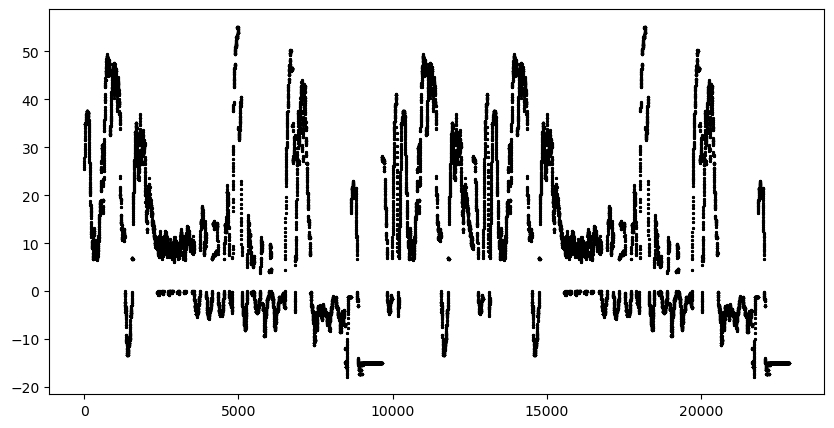

In [79]:
%matplotlib inline


t = np.linspace(0, y_dn.shape[0], y_dn.shape[0])



with torch.no_grad():
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(1, 1, 1)

        # Get upper and lower confidence bounds
#         lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
    ax.plot(t, y_dn, 'k*', markersize=2, label='predictions')
        # Plot predictive means as blue line
    ax.plot(t, p_dn, 'bo', markersize=2, label='observed data')
        # Shade between the lower and upper confidence bounds
#         ax.plot(overlap_t, overlap_y[:, i], "rx", markersize=20, label='overlap between trainset and testset')
    ax.set_title("control command")
    ax.axhline(0)
    ax.fill_between(t, l_dn, u_dn, alpha=0.5)


In [ ]:
class MeanVarModelWrapper(torch.nn.Module):
    def __init__(self, gp):
        super().__init__()
        self.gp = gp

    def forward(self, x):
        output_dist = self.gp(x)
        return output_dist.mean, output_dist.variance

In [ ]:
wrapped_model = MeanVarModelWrapper(model)

with torch.no_grad(), gpytorch.settings.trace_mode():
    fake_input = x_tensor_t
    pred = wrapped_model(fake_input)  # Compute caches
    traced_model = torch.jit.trace(wrapped_model, fake_input)

In [ ]:
traced_model.save('longitudinal_dynamics_svgp_cpu.pt')

In [ ]:
x_shifter

In [ ]:
x_normalizer